In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
file_dir = "/kaggle/input/dataset-plastik"
os.listdir(file_dir)

['hdpe_container',
 'hdpe_botol',
 'ps',
 'pp_tutup_botol',
 'pp_botol',
 'pp_sedotan',
 'pet',
 'pp_container',
 'ldpe_bag',
 'ldpe_botol',
 'hdpe_tutup_botol']

In [4]:
img_height, img_width = (200, 200)
IMG_SIZE = (img_height, img_width)
IMG_SIZE_WITH_RGB = IMG_SIZE+(3,)
batch_size = 32

data_directory = "/kaggle/input/dataset-plastik"

In [5]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=data_directory,
    subset="training",
    validation_split=0.2,
    seed=2023,
    image_size=IMG_SIZE,
    batch_size=batch_size
)

validation_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=data_directory,
    subset="validation",
    validation_split=0.2,
    seed=2023,
    image_size=IMG_SIZE,
    batch_size=batch_size
)

Found 618 files belonging to 11 classes.
Using 495 files for training.
Found 618 files belonging to 11 classes.
Using 123 files for validation.


In [6]:
train_data.class_names

class_names = train_data.class_names

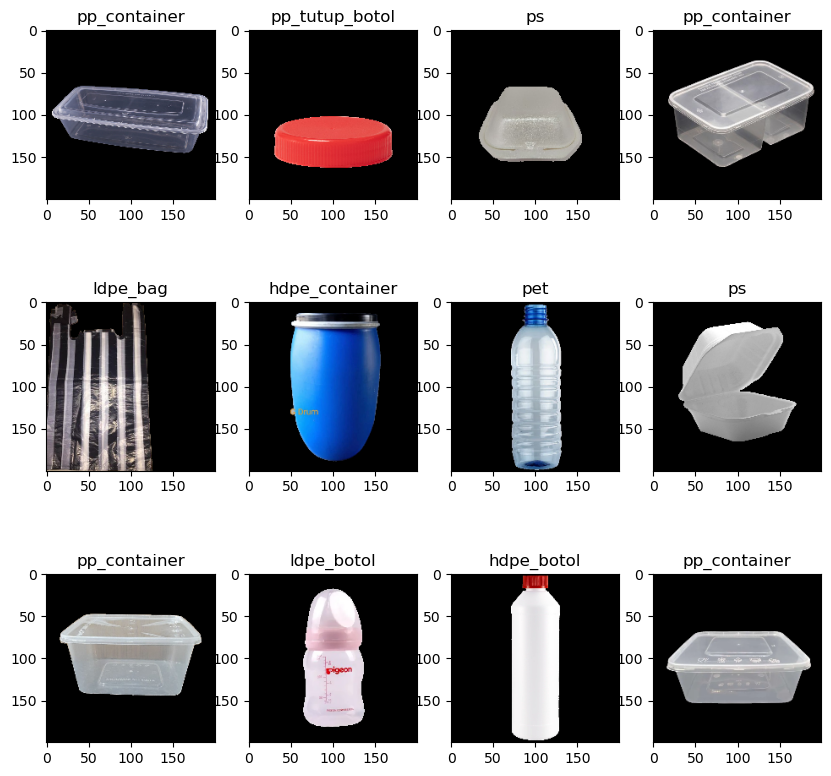

In [7]:
image_batch, label_batch = next(iter(train_data))

plt.figure(figsize=(10,10))
for i in range (12):
    
    ax = plt.subplot(3,4, i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = class_names[label_batch[i]]
    plt.title(label)


In [8]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE_WITH_RGB,
    include_top=False,
    weights="imagenet"
)
base_model.trainable = True

9406464/9406464 [==============================] - 0s 0us/step


In [9]:
image_batch, label_batch = next(iter(train_data))
feature_batch = base_model(image_batch)

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_avg = global_average_layer(feature_batch)

prediction_layer = tf.keras.layers.Dense(len(class_names), activation="softmax")

In [10]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomContrast(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
])

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy') >= 0.9):
      self.model.stop_training = True

callbacks = myCallback()

In [11]:
dropout_param = 0.4
learning_rate = 1e-4

model = tf.keras.Sequential([
    tf.keras.Input(shape=IMG_SIZE_WITH_RGB),
    data_augmentation,
    tf.keras.layers.Lambda(preprocess_input),
    base_model,   
    global_average_layer,
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(dropout_param),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(dropout_param),
    tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dense(256, activation="relu"),
#     tf.keras.layers.Dropout(dropout_param),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dense(512, activation="relu"),
#     tf.keras.layers.Dropout(dropout_param),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dense(1024, activation="relu"),
#     tf.keras.layers.Dropout(dropout_param),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dense(2048, activation="relu"),
#     tf.keras.layers.Dropout(dropout_param),
#     tf.keras.layers.BatchNormalization(),
    prediction_layer
])



model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [12]:
initial_epochs = 300

loss0, accuracy0 = model.evaluate(validation_data)
print(loss0, accuracy0)

/opt/conda/lib/python3.10/site-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


4/4 [==============================] - 5s 197ms/step - loss: 2.2851 - accuracy: 0.1545
2.2850961685180664 0.15447154641151428


In [13]:
history = model.fit(train_data,
                    epochs=initial_epochs,
                    validation_data=validation_data, callbacks=[callbacks])

Epoch 1/300
16/16 [==============================] - 47s 427ms/step - loss: 2.8779 - accuracy: 0.1394 - val_loss: 2.1831 - val_accuracy: 0.2683
Epoch 2/300
16/16 [==============================] - 9s 386ms/step - loss: 2.5176 - accuracy: 0.1899 - val_loss: 2.0541 - val_accuracy: 0.3577
Epoch 3/300
16/16 [==============================] - 8s 335ms/step - loss: 2.1644 - accuracy: 0.2727 - val_loss: 1.9214 - val_accuracy: 0.4228
Epoch 4/300
16/16 [==============================] - 8s 304ms/step - loss: 2.0381 - accuracy: 0.2990 - val_loss: 1.8128 - val_accuracy: 0.4797
Epoch 5/300
16/16 [==============================] - 8s 312ms/step - loss: 1.8375 - accuracy: 0.3717 - val_loss: 1.7026 - val_accuracy: 0.4878
Epoch 6/300
16/16 [==============================] - 8s 309ms/step - loss: 1.7632 - accuracy: 0.4121 - val_loss: 1.6354 - val_accuracy: 0.5122
Epoch 7/300
16/16 [==============================] - 8s 361ms/step - loss: 1.5126 - accuracy: 0.5172 - val_loss: 1.5766 - val_accuracy: 0.544

In [14]:
import pickle

model_file_path = "9NewDataset_MobileNetV2_1e-4_80Split_Adam_Dense_with02Dropout.pkl"
with open(model_file_path, "wb") as file:
    pickle.dump(model, file)

In [15]:
model.save("9NewData_Fixed_MobileNetV2_1e-4_80Split_Adam_Dense_with02Dropout.h5")

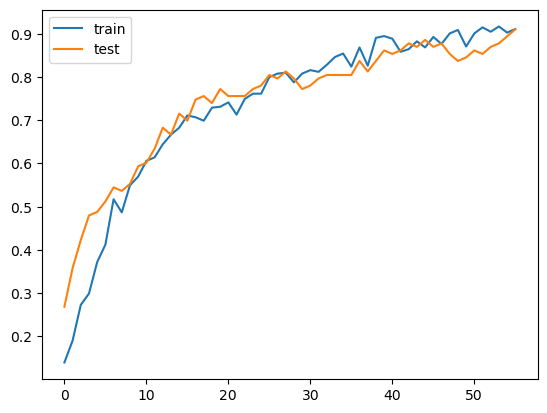

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train', 'test'], loc='upper left')


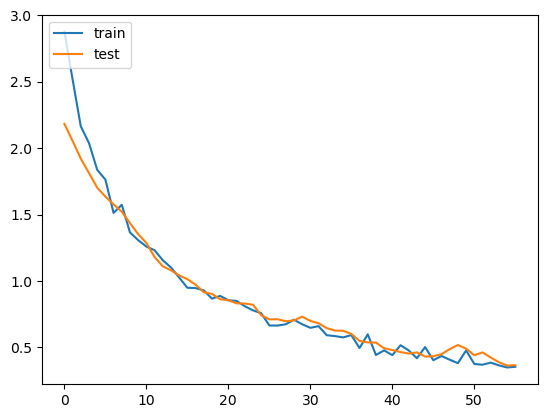

In [17]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'test'], loc='upper left')

1/1 [==============================] - 0s 30ms/step
[[0.18836501 0.04111283 0.22586493 0.03058272 0.08726066 0.09496951
  0.04276862 0.03359749 0.07715619 0.1282065  0.05011549]]
hdpe_tutup_botol


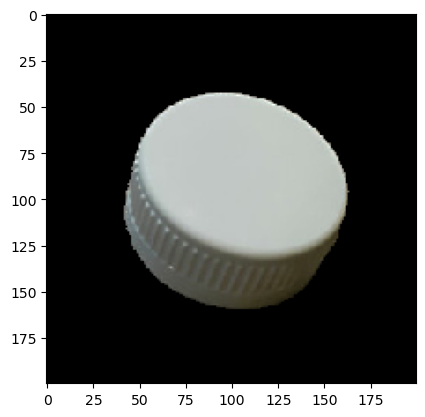

In [21]:
import os

filepath = "/kaggle/input/dataset-plastik/hdpe_tutup_botol/0_3670e5cd-0a41-4ce7-832e-dc9f9d6161ef_720_1280 (1) Background Removed.png"
image = tf.keras.preprocessing.image.load_img(filepath, target_size=(200,200))
plt.imshow(image)
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])
input_arr = input_arr.astype('float32') / 255
result = model.predict(input_arr)
print(result)
print(class_names[np.argmax(result)])

In [19]:
# from sklearn.metrics import confusion_matrix
# import numpy as np

# # Assuming you have an image data generator named 'test_generator' and a model named 'model'

# # Generate predictions using the model and the image data generator
# y_pred = model.predict_generator(validation_data)
# y_pred = np.argmax(y_pred, axis=1)

# # Get the true labels from the image data generator
# y_true = validation_data.classes

# # Calculate the confusion matrix
# conf_mat = confusion_matrix(y_true, y_pred)


/tmp/ipykernel_28/2602620889.py:7: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model.predict_generator(validation_data)


AttributeError: '_BatchDataset' object has no attribute 'classes'